<a href="https://colab.research.google.com/github/Abdullah-Al-Arafat/CAP-5610-Machine-Learning/blob/master/ML_hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-04-17 06:11:41--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.126.128, 2607:f8b0:4001:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   145MB/s    in 0.5s    

2019-04-17 06:11:42 (145 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [3]:
from keras.applications import VGG19

conv_base = VGG19(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
80142336/80134624 [==============================] - 1s 0us/step


In [0]:
conv_base.trainable = False

In [5]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 22,122,049
Trainable params: 2,097,665
Non-trainable params: 20,024,384
_________________________________________________________________


In [6]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

## Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

## We don't do the Data augmentation for validation dataset(except normalization)
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# Compile Model
model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=1e-4), 
    metrics=['acc'])

# Train the network
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
100/100 [==============================] - 23s 228ms/step - loss: 0.5766 - acc: 0.6950 - val_loss: 0.3577 - val_acc: 0.8390
Epoch 2/30
100/100 [==============================] - 18s 176ms/step - loss: 0.4465 - acc: 0.7895 - val_loss: 0.3124 - val_acc: 0.8670
Epoch 3/30
100/100 [==============================] - 18s 183ms/step - loss: 0.4162 - acc: 0.8075 - val_loss: 0.3118 - val_acc: 0.8680
Epoch 4/30
100/100 [==============================] - 18s 177ms/step - loss: 0.3914 - acc: 0.8090 - val_loss: 0.2751 - val_acc: 0.8830
Epoch 5/30
100/100 [==============================] - 18s 185ms/step - loss: 0.3930 - acc: 0.8145 - val_loss: 0.2805 - val_acc: 0.8720
Epoch 6/30
100/100 [==============================] - 18s 176ms/step - loss: 0.3890 - acc: 0.8190 - val_loss: 0.2844 - val_acc: 0.8730
Epoch 7/30
100/100 [==============================] - 19s 

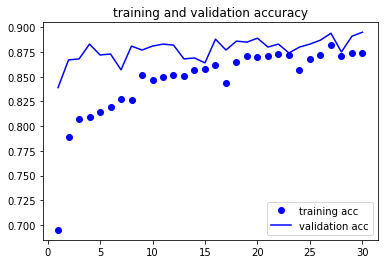

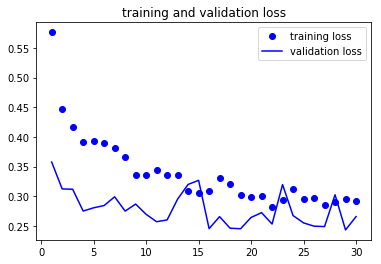

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()


# training and validation loss
plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

In [8]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

model_fname = 'cats_and_dogs_small_Feat_extraction.h5' 
model.save(model_fname)

from google.colab import files

with open(model_fname, 'r') as f:
  files.download(model_fname)

Validation loss: 0.2627834318578243
Validation accuracy: 0.8939999949932098


**Playing with the model**

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block2_conv1':
    set_trainable = True
  if layer.name == 'block4_conv1':
    set_trainable = True
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [10]:
# Compile the Model
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# Train the model 
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/20
100/100 [==============================] - 25s 250ms/step - loss: 0.2853 - acc: 0.8880 - val_loss: 0.1947 - val_acc: 0.9310
Epoch 2/20
100/100 [==============================] - 22s 223ms/step - loss: 0.2027 - acc: 0.9135 - val_loss: 0.1270 - val_acc: 0.9510
Epoch 3/20
100/100 [==============================] - 23s 226ms/step - loss: 0.1734 - acc: 0.9315 - val_loss: 0.2667 - val_acc: 0.9260
Epoch 4/20
100/100 [==============================] - 23s 228ms/step - loss: 0.1240 - acc: 0.9500 - val_loss: 0.2108 - val_acc: 0.9470
Epoch 5/20
100/100 [==============================] - 23s 228ms/step - loss: 0.1204 - acc: 0.9505 - val_loss: 0.1101 - val_acc: 0.9590
Epoch 6/20
100/100 [==============================] - 23s 226ms/step - loss: 0.1099 - acc: 0.9590 - val_loss: 0.1436 - val_acc: 0.9520
Epoch 7/20
100/100 [==============================] - 23s 226ms/step - loss: 0.0962 - acc: 0.9695 - val_loss: 0.0967 - val_acc: 0.9690
Epoch 8/20
100/100 [==============================] - 2

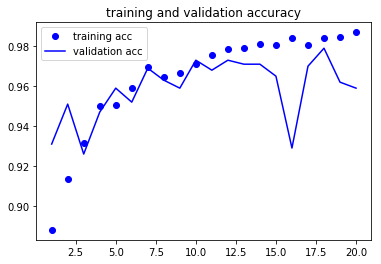

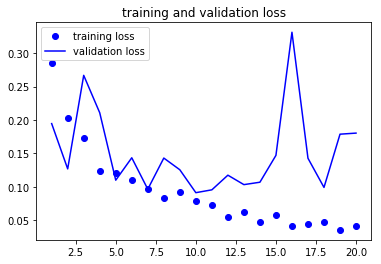

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Training and validation accuracy
plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# Training and validation loss
plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

In [12]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.18789453191202482
Validation accuracy: 0.9569999921321869


In [0]:
model_fname = 'cats_and_dogs_small_Fine_tuning.h5' 
model.save(model_fname)

from google.colab import files

with open(model_fname, 'r') as f:
  files.download(model_fname)

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 22,122,049
Trainable params: 22,083,329
Non-trainable params: 38,720
_________________________________________________________________


In [31]:
model.layers[0].output

AttributeError: ignored

In [26]:
img_path = '/tmp/cats_and_dogs_filtered/validation/dogs/dog.2001.jpg'

from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

from keras import models

layer_outputs = [model.get_layer[:i].output for i in range(8)]

activation_model = models.Model(input=model.input, outputs=layer_outputs)

activations = activation_model.predict(img_tensor)
first_layer_activation = activations[7]

print(first_layer_activation.shape)
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')
plt.grid(None)
plt.show()

TypeError: ignored